In [1]:
from pixel_cnn import PixelCNN
from flax import nnx
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import optax
import treescope
import keras
import tqdm
treescope.register_as_default()

2025-07-27 21:37:51.233780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-27 21:37:51.244348: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-27 21:37:51.247805: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import wandb
wandb.login()

wandb: Currently logged in as: apoorvreddy to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [4]:
def display_image_grid(images, grid_shape):
    assert images.shape[0] == grid_shape[0] * grid_shape[1]
    fig, axes = plt.subplots(grid_shape[0], grid_shape[1], figsize=grid_shape)
    fig.patch.set_facecolor('black') # Set background to black for better contrast
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    for i, ax in enumerate(axes.flat):
        img_to_show = images[i]
        ax.imshow(img_to_show, cmap='gray')
        ax.axis('off') # Hide the x and y axes
    plt.show()

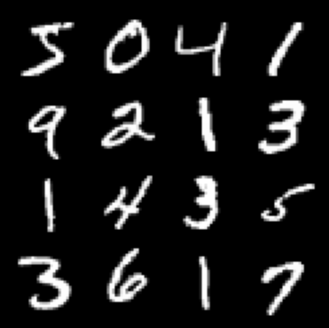

In [5]:
display_image_grid(x_train[:16], (4, 4))

In [6]:
class Batcher:
    def __init__(self, images, batch_size, binarize: bool = False):
        self.images = images
        self.bsz = batch_size
        self.iter = 0
        self.binarize = binarize
    
    def get_batch(self):
        if (self.iter + 1) * self.bsz < self.images.shape[0]:
            start_idx = self.iter * self.bsz
            end_idx = (self.iter + 1) * self.bsz
            self.iter += 1
            batch = (self.images[start_idx: end_idx][..., jnp.newaxis])
            if self.binarize:
                return batch/256.0 > 0.5
            return batch
        else:
            self.shuffle()
            return self.get_batch()
    
    def shuffle(self):
        np.random.shuffle(self.images)
        self.iter = 0

In [7]:
def compute_nll(logits_bmnd, im_bmnc):
    # compute negative log-likelihood of a batch
    logprob_bmnd = nnx.log_softmax(logits_bmnd)
    logprob_bmn = logprob_bmnd[im_bmnc[:,:,:,0]]
    return -jnp.mean(jnp.sum(logprob_bmn, axis=[1, 2]))

def compute_loss(model, image_batch, binarize):
    logits = model(image_batch)
    if binarize:
        labels = image_batch
        loss = optax.sigmoid_binary_cross_entropy(logits, labels)
        loss = jnp.mean(loss)
    else:
        labels = nnx.one_hot(image_batch[:,:,:,0], 256)
        loss = optax.softmax_cross_entropy(logits, labels, axis=-1)
        loss = jnp.mean(loss)
    return loss

def compute_metrics(model, image_batch, binarize):
    logits = model(image_batch)

    if binarize:
        labels = image_batch
        loss = optax.sigmoid_binary_cross_entropy(logits, labels)
        nll = jnp.mean(jnp.sum(loss, axis=[1, 2]))
        loss = jnp.mean(loss)

        top1_accuracy = ((logits > 0).astype(jnp.int8) == image_batch)
        top1_accuracy = jnp.mean(jnp.mean(top1_accuracy, axis=[1, 2]))

    else:
        labels = nnx.one_hot(image_batch[:,:,:,0], 256)
        loss = optax.softmax_cross_entropy(logits, labels, axis=-1)
        loss = jnp.mean(loss)

        top1_accuracy = (jnp.argmax(logits) == image_batch[:,:,:,0])
        top1_accuracy = jnp.mean(jnp.mean(top1_accuracy, axis=[1, 2]))
    
        nll = compute_nll(logits, image_batch, binarize)

    return loss, top1_accuracy, nll


@nnx.jit(static_argnames=['binarize'])
def train_step(model, optimizer, batch, binarize):
    grad_fn = nnx.value_and_grad(compute_loss)
    loss, grads = grad_fn(model, batch, binarize)
    optimizer.update(grads)
    return loss

@nnx.jit(static_argnames=['binarize'])
def eval_step(model, batch, eval_metrics, binarize):
    loss, top1_accuracy, nll = compute_metrics(model, batch, binarize)

    eval_metrics.update(
        loss=loss,
        accuracy=top1_accuracy,
        nll=nll
    )

In [8]:
def count_params(model):
    params = nnx.state(model, nnx.Param)
    total_params  = sum(np.prod(x.shape) for x in jax.tree_util.tree_leaves(params))
    print(total_params)

    for path, x in jax.tree_util.tree_leaves_with_path(params):
        print(path, np.prod(x.shape))
    return total_params

## Overfit on one image

113889
(DictKey(key='head'), DictKey(key='bias'), GetAttrKey(name='value')) 1
(DictKey(key='head'), DictKey(key='kernel'), GetAttrKey(name='value')) 32
(DictKey(key='input_conv'), DictKey(key='bias'), GetAttrKey(name='value')) 64
(DictKey(key='input_conv'), DictKey(key='kernel'), GetAttrKey(name='value')) 3136
(DictKey(key='layers'), DictKey(key=0), DictKey(key='conv'), DictKey(key='bias'), GetAttrKey(name='value')) 32
(DictKey(key='layers'), DictKey(key=0), DictKey(key='conv'), DictKey(key='kernel'), GetAttrKey(name='value')) 9216
(DictKey(key='layers'), DictKey(key=0), DictKey(key='in_conv'), DictKey(key='conv'), DictKey(key='bias'), GetAttrKey(name='value')) 32
(DictKey(key='layers'), DictKey(key=0), DictKey(key='in_conv'), DictKey(key='conv'), DictKey(key='kernel'), GetAttrKey(name='value')) 2048
(DictKey(key='layers'), DictKey(key=0), DictKey(key='out_conv'), DictKey(key='conv'), DictKey(key='bias'), GetAttrKey(name='value')) 64
(DictKey(key='layers'), DictKey(key=0), DictKey(key=

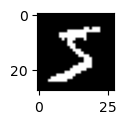

In [26]:
batcher = Batcher(x_train, 1, binarize=True)
batch = batcher.get_batch()

plt.figure(figsize=(1, 1))
plt.imshow(batch[0], cmap='gray')

rngs = nnx.Rngs(params=0)

features=32
output_conv_out_channels = [32, 32]
num_layers = 8
preds_dim = 1

model = PixelCNN(features=features,
                num_layers=num_layers,
                output_conv_out_channels=output_conv_out_channels,
                preds_dim=1,
                is_rgb=False,
                rngs=rngs)
num_params = count_params(model)
optimizer = nnx.Optimizer(model, optax.rmsprop(
    learning_rate=1e-3,
))


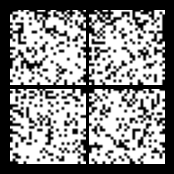

In [28]:
gen_image_batch = model.generate(28, 28, 4, jax.random.key(2))
display_image_grid(gen_image_batch[:,:,:,0], (2, 2))

In [29]:
for i in range(1000):
    loss = train_step(model, optimizer, batch, binarize=True)
    print(f"loss[{i}]: {loss}")

loss[0]: 0.7993022203445435
loss[1]: 0.6937466859817505
loss[2]: 0.6750273108482361
loss[3]: 0.6529342532157898
loss[4]: 0.6305066347122192
loss[5]: 0.59825599193573
loss[6]: 0.5478186011314392
loss[7]: 0.4944365918636322
loss[8]: 0.523061990737915
loss[9]: 0.5175783634185791
loss[10]: 0.3990451693534851
loss[11]: 0.3350946307182312
loss[12]: 0.28959986567497253
loss[13]: 0.2716793417930603
loss[14]: 0.35171282291412354
loss[15]: 0.3972953259944916
loss[16]: 0.2629232406616211
loss[17]: 0.23679529130458832
loss[18]: 0.21963150799274445
loss[19]: 0.20673198997974396
loss[20]: 0.19447898864746094
loss[21]: 0.18372783064842224
loss[22]: 0.17403294146060944
loss[23]: 0.16807208955287933
loss[24]: 0.2021544724702835
loss[25]: 0.3486178517341614
loss[26]: 0.23172366619110107
loss[27]: 0.1796790510416031
loss[28]: 0.15861806273460388
loss[29]: 0.14892373979091644
loss[30]: 0.1413225680589676
loss[31]: 0.13474707305431366
loss[32]: 0.1283467561006546
loss[33]: 0.12239453941583633
loss[34]: 0.1

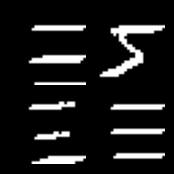

In [32]:
gen_image_batch = model.generate(28, 28, 4, jax.random.key(2))
display_image_grid(gen_image_batch[:,:,:,0], (2, 2))

## Train on entire MNIST dataset.

In [33]:
bar_format = "{desc}[{n_fmt}/{total_fmt}]{postfix} [{elapsed}<{remaining}]"
batch_size = 16
train_total_steps = x_train.shape[0] // batch_size
num_epochs = 60
eval_total_steps = x_test.shape[0] // batch_size
binarize = True


eval_metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average('loss'),
    accuracy=nnx.metrics.Average('accuracy'),
    nll=nnx.metrics.Average('nll')
)

train_metrics_history = {
    "train_loss": [],
}

eval_metrics_history = {
    "test_loss": [],
    "test_accuracy": [],
    "test_nll": []
}

def train_one_epoch(epoch, model, optimizer, binarize):
    model.train()  # Set model to the training mode: e.g. update batch statistics
    with tqdm.tqdm(
        desc=f"[train] epoch: {epoch}/{num_epochs}, ",
        total=train_total_steps,
        bar_format=bar_format,
        leave=True,
    ) as pbar:
        batcher = Batcher(x_train, batch_size, binarize)
        batcher.shuffle()
        for i in range(train_total_steps):
            batch = batcher.get_batch()
            loss = train_step(model, optimizer, batch, binarize)
            train_metrics_history["train_loss"].append(loss.item())
            wandb.log({"train_loss": loss.item(), "samples": epoch * train_total_steps * batch_size + (i+1) * batch_size})
            pbar.set_postfix({"loss": loss.item()})
            pbar.update(1)


def evaluate_model(epoch, model, binarize):
    # Compute the metrics on the train and val sets after each training epoch.
    model.eval()  # Set model to evaluation model: e.g. use stored batch statistics
    with tqdm.tqdm(
        desc=f"[eval] epoch: {epoch}/{num_epochs}, ",
        total=eval_total_steps,
        bar_format=bar_format,
        leave=True,
    ) as pbar:
        eval_metrics.reset()  # Reset the eval metrics
        batcher = Batcher(x_test, batch_size, binarize)
        for i in range(eval_total_steps):
            batch = batcher.get_batch()
            eval_step(model, batch, eval_metrics, binarize)
            pbar.update(1)

        for metric, value in eval_metrics.compute().items():
            wandb.log({f'test_{metric}': value})
            eval_metrics_history[f'test_{metric}'].append(value)

    print(f"[eval] epoch: {epoch}/{num_epochs}")
    print(f"- total loss: {eval_metrics_history['test_loss'][-1]:0.4f}")
    print(f"- Accuracy: {eval_metrics_history['test_accuracy'][-1]:0.4f}")
    print(f"- NLL: {eval_metrics_history['test_nll'][-1]:0.4f}")

In [42]:
#@title Training Config

# data

rngs = nnx.Rngs(params=0)
# model
features=128
output_conv_out_channels = [32, 32]
num_layers = 8
preds_dim = 1

#lr_scheduler
lr_init_value=1e-7
lr_peak_value=1e-4
lr_warmup_steps=200
lr_decay_steps=125000

run = wandb.init(
    project="pixel-rnn-mnist",  # Specify your project
    config={                        # Track hyperparameters and metadata
        "lr_scheduler": {
            'init_value': lr_init_value,
            'peak_value': lr_peak_value,
            'warmup_steps': lr_warmup_steps,
            'decay_steps': lr_decay_steps
        },
        "model": {
            "features": features,
            "input_conv_kernel": (7, 7),
            "output_conv_channels": output_conv_out_channels,
            "residual_connections": True,
            "num_layers": num_layers,
            "preds_dim": preds_dim
        },
        "training": {
            "batch_size": batch_size,
            "epochs": num_epochs,
            "binarize": binarize
        },
        "architecture": "pixel-cnn"
    },
)

wandb.define_metric("train_loss", step_metric="samples")
wandb.define_metric("test_nll", step_metric="samples")
wandb.define_metric("test_accuracy", step_metric="samples")
wandb.define_metric("test_loss", step_metric="samples")

samples,▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██████
test_accuracy,▁▃▅▅▆▆▇▇▇▇▇▇████████████████████████████
test_loss,█▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_nll,█▆▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▄▄▅▅▃▆▄▂▃▂▂▃▃▃▃▃▄▃▁▁▅▄▃▄▁▅▃▂▂▂▂▂▄▃▂▅▃▃
samples,3600000.0
test_accuracy,0.96683
test_loss,0.0813
test_nll,63.74271
train_loss,0.08456


In [43]:
model = PixelCNN(features=features,
                num_layers=num_layers,
                output_conv_out_channels=output_conv_out_channels,
                preds_dim=1,
                is_rgb=False,
                rngs=rngs)
lr_scheduler = optax.warmup_cosine_decay_schedule(
    init_value=lr_init_value,
    peak_value=lr_peak_value,
    warmup_steps=lr_warmup_steps,
    decay_steps=lr_decay_steps
)
optimizer = nnx.Optimizer(model, optax.rmsprop(lr_scheduler))

In [44]:
for epoch in range(num_epochs):
    train_one_epoch(epoch, model, optimizer, binarize)
    evaluate_model(epoch, model, binarize)

[train] epoch: 0/60, [3750/3750], loss=0.0894 [01:15<00:00]
[eval] epoch: 0/60, [625/625] [00:03<00:00]


[eval] epoch: 0/60
- total loss: 0.0895
- Accuracy: 0.9635
- NLL: 70.1862


[train] epoch: 1/60, [3750/3750], loss=0.0955 [01:10<00:00]
[eval] epoch: 1/60, [625/625] [00:03<00:00]


[eval] epoch: 1/60
- total loss: 0.0866
- Accuracy: 0.9648
- NLL: 67.8910


[train] epoch: 2/60, [3750/3750], loss=0.0784 [01:09<00:00]
[eval] epoch: 2/60, [625/625] [00:02<00:00]


[eval] epoch: 2/60
- total loss: 0.0853
- Accuracy: 0.9653
- NLL: 66.8702


[train] epoch: 3/60, [3750/3750], loss=0.0844 [01:09<00:00]
[eval] epoch: 3/60, [625/625] [00:02<00:00]


[eval] epoch: 3/60
- total loss: 0.0848
- Accuracy: 0.9654
- NLL: 66.4762


[train] epoch: 4/60, [3750/3750], loss=0.0857 [01:08<00:00]
[eval] epoch: 4/60, [625/625] [00:03<00:00]


[eval] epoch: 4/60
- total loss: 0.0835
- Accuracy: 0.9660
- NLL: 65.4718


[train] epoch: 5/60, [3750/3750], loss=0.096 [01:09<00:00] 
[eval] epoch: 5/60, [625/625] [00:03<00:00]


[eval] epoch: 5/60
- total loss: 0.0836
- Accuracy: 0.9660
- NLL: 65.5695


[train] epoch: 6/60, [3750/3750], loss=0.0838 [01:11<00:00]
[eval] epoch: 6/60, [625/625] [00:02<00:00]


[eval] epoch: 6/60
- total loss: 0.0829
- Accuracy: 0.9662
- NLL: 64.9727


[train] epoch: 7/60, [3750/3750], loss=0.0721 [01:12<00:00]
[eval] epoch: 7/60, [625/625] [00:03<00:00]


[eval] epoch: 7/60
- total loss: 0.0823
- Accuracy: 0.9666
- NLL: 64.4896


[train] epoch: 8/60, [3750/3750], loss=0.0885 [01:11<00:00]
[eval] epoch: 8/60, [625/625] [00:03<00:00]


[eval] epoch: 8/60
- total loss: 0.0821
- Accuracy: 0.9665
- NLL: 64.3717


[train] epoch: 9/60, [3750/3750], loss=0.0834 [01:19<00:00]
[eval] epoch: 9/60, [625/625] [00:03<00:00]


[eval] epoch: 9/60
- total loss: 0.0816
- Accuracy: 0.9668
- NLL: 63.9706


[train] epoch: 10/60, [3750/3750], loss=0.0701 [01:09<00:00]
[eval] epoch: 10/60, [625/625] [00:03<00:00]


[eval] epoch: 10/60
- total loss: 0.0815
- Accuracy: 0.9668
- NLL: 63.8946


[train] epoch: 11/60, [3750/3750], loss=0.0729 [01:08<00:00]
[eval] epoch: 11/60, [625/625] [00:03<00:00]


[eval] epoch: 11/60
- total loss: 0.0812
- Accuracy: 0.9670
- NLL: 63.6258


[train] epoch: 12/60, [3750/3750], loss=0.0793 [01:09<00:00]
[eval] epoch: 12/60, [625/625] [00:02<00:00]


[eval] epoch: 12/60
- total loss: 0.0813
- Accuracy: 0.9669
- NLL: 63.7033


[train] epoch: 13/60, [3750/3750], loss=0.0836 [01:10<00:00]
[eval] epoch: 13/60, [625/625] [00:02<00:00]


[eval] epoch: 13/60
- total loss: 0.0809
- Accuracy: 0.9671
- NLL: 63.4281


[train] epoch: 14/60, [3750/3750], loss=0.0774 [01:10<00:00]
[eval] epoch: 14/60, [625/625] [00:02<00:00]


[eval] epoch: 14/60
- total loss: 0.0808
- Accuracy: 0.9670
- NLL: 63.3727


[train] epoch: 15/60, [3750/3750], loss=0.0797 [01:09<00:00]
[eval] epoch: 15/60, [625/625] [00:02<00:00]


[eval] epoch: 15/60
- total loss: 0.0809
- Accuracy: 0.9670
- NLL: 63.4390


[train] epoch: 16/60, [3750/3750], loss=0.0796 [01:08<00:00]
[eval] epoch: 16/60, [625/625] [00:03<00:00]


[eval] epoch: 16/60
- total loss: 0.0806
- Accuracy: 0.9672
- NLL: 63.2252


[train] epoch: 17/60, [3750/3750], loss=0.0821 [01:09<00:00]
[eval] epoch: 17/60, [625/625] [00:03<00:00]


[eval] epoch: 17/60
- total loss: 0.0805
- Accuracy: 0.9671
- NLL: 63.1229


[train] epoch: 18/60, [3750/3750], loss=0.0765 [01:09<00:00]
[eval] epoch: 18/60, [625/625] [00:03<00:00]


[eval] epoch: 18/60
- total loss: 0.0805
- Accuracy: 0.9672
- NLL: 63.1447


[train] epoch: 19/60, [3750/3750], loss=0.0808 [01:12<00:00]
[eval] epoch: 19/60, [625/625] [00:02<00:00]


[eval] epoch: 19/60
- total loss: 0.0804
- Accuracy: 0.9673
- NLL: 63.0062


[train] epoch: 20/60, [3750/3750], loss=0.0692 [01:10<00:00]
[eval] epoch: 20/60, [625/625] [00:03<00:00]


[eval] epoch: 20/60
- total loss: 0.0804
- Accuracy: 0.9672
- NLL: 63.0022


[train] epoch: 21/60, [3750/3750], loss=0.0778 [01:10<00:00]
[eval] epoch: 21/60, [625/625] [00:02<00:00]


[eval] epoch: 21/60
- total loss: 0.0802
- Accuracy: 0.9673
- NLL: 62.8808


[train] epoch: 22/60, [3750/3750], loss=0.0735 [01:09<00:00]
[eval] epoch: 22/60, [625/625] [00:02<00:00]


[eval] epoch: 22/60
- total loss: 0.0802
- Accuracy: 0.9673
- NLL: 62.8851


[train] epoch: 23/60, [3750/3750], loss=0.0862 [01:13<00:00]
[eval] epoch: 23/60, [625/625] [00:02<00:00]


[eval] epoch: 23/60
- total loss: 0.0802
- Accuracy: 0.9672
- NLL: 62.9081


[train] epoch: 24/60, [3750/3750], loss=0.0725 [01:13<00:00]
[eval] epoch: 24/60, [625/625] [00:02<00:00]


[eval] epoch: 24/60
- total loss: 0.0802
- Accuracy: 0.9673
- NLL: 62.8906


[train] epoch: 25/60, [3750/3750], loss=0.0814 [01:12<00:00]
[eval] epoch: 25/60, [625/625] [00:03<00:00]


[eval] epoch: 25/60
- total loss: 0.0801
- Accuracy: 0.9673
- NLL: 62.7785


[train] epoch: 26/60, [3750/3750], loss=0.0819 [01:13<00:00]
[eval] epoch: 26/60, [625/625] [00:03<00:00]


[eval] epoch: 26/60
- total loss: 0.0801
- Accuracy: 0.9673
- NLL: 62.8143


[train] epoch: 27/60, [3750/3750], loss=0.0768 [01:12<00:00]
[eval] epoch: 27/60, [625/625] [00:02<00:00]


[eval] epoch: 27/60
- total loss: 0.0801
- Accuracy: 0.9674
- NLL: 62.8071


[train] epoch: 28/60, [3750/3750], loss=0.0787 [01:12<00:00]
[eval] epoch: 28/60, [625/625] [00:03<00:00]


[eval] epoch: 28/60
- total loss: 0.0801
- Accuracy: 0.9673
- NLL: 62.7886


[train] epoch: 29/60, [3750/3750], loss=0.0779 [01:12<00:00]
[eval] epoch: 29/60, [625/625] [00:02<00:00]


[eval] epoch: 29/60
- total loss: 0.0801
- Accuracy: 0.9673
- NLL: 62.7823


[train] epoch: 30/60, [3750/3750], loss=0.0732 [01:11<00:00]
[eval] epoch: 30/60, [625/625] [00:03<00:00]


[eval] epoch: 30/60
- total loss: 0.0801
- Accuracy: 0.9674
- NLL: 62.7795


[train] epoch: 31/60, [3750/3750], loss=0.0784 [01:11<00:00]
[eval] epoch: 31/60, [625/625] [00:02<00:00]


[eval] epoch: 31/60
- total loss: 0.0800
- Accuracy: 0.9674
- NLL: 62.7568


[train] epoch: 32/60, [3750/3750], loss=0.0814 [01:12<00:00]
[eval] epoch: 32/60, [625/625] [00:03<00:00]


[eval] epoch: 32/60
- total loss: 0.0801
- Accuracy: 0.9673
- NLL: 62.7848


[train] epoch: 33/60, [3750/3750], loss=0.0778 [01:12<00:00]
[eval] epoch: 33/60, [625/625] [00:03<00:00]


[eval] epoch: 33/60
- total loss: 0.0801
- Accuracy: 0.9674
- NLL: 62.7717


[train] epoch: 34/60, [3750/3750], loss=0.0727 [01:12<00:00]
[eval] epoch: 34/60, [625/625] [00:02<00:00]


[eval] epoch: 34/60
- total loss: 0.0800
- Accuracy: 0.9674
- NLL: 62.7572


[train] epoch: 35/60, [3750/3750], loss=0.0742 [01:14<00:00]
[eval] epoch: 35/60, [625/625] [00:03<00:00]


[eval] epoch: 35/60
- total loss: 0.0801
- Accuracy: 0.9674
- NLL: 62.7711


[train] epoch: 36/60, [3750/3750], loss=0.0743 [01:10<00:00]
[eval] epoch: 36/60, [625/625] [00:03<00:00]


[eval] epoch: 36/60
- total loss: 0.0800
- Accuracy: 0.9674
- NLL: 62.7541


[train] epoch: 37/60, [3750/3750], loss=0.0723 [01:09<00:00]
[eval] epoch: 37/60, [625/625] [00:02<00:00]


[eval] epoch: 37/60
- total loss: 0.0801
- Accuracy: 0.9674
- NLL: 62.7705


[train] epoch: 38/60, [3750/3750], loss=0.0796 [01:10<00:00]
[eval] epoch: 38/60, [625/625] [00:02<00:00]


[eval] epoch: 38/60
- total loss: 0.0800
- Accuracy: 0.9674
- NLL: 62.7588


[train] epoch: 39/60, [3750/3750], loss=0.0834 [01:10<00:00]
[eval] epoch: 39/60, [625/625] [00:02<00:00]


[eval] epoch: 39/60
- total loss: 0.0800
- Accuracy: 0.9674
- NLL: 62.7552


[train] epoch: 40/60, [3750/3750], loss=0.0793 [01:10<00:00]
[eval] epoch: 40/60, [625/625] [00:02<00:00]


[eval] epoch: 40/60
- total loss: 0.0801
- Accuracy: 0.9674
- NLL: 62.7716


[train] epoch: 41/60, [3750/3750], loss=0.0709 [01:11<00:00]
[eval] epoch: 41/60, [625/625] [00:02<00:00]


[eval] epoch: 41/60
- total loss: 0.0801
- Accuracy: 0.9674
- NLL: 62.7639


[train] epoch: 42/60, [3750/3750], loss=0.0807 [01:11<00:00]
[eval] epoch: 42/60, [625/625] [00:02<00:00]


[eval] epoch: 42/60
- total loss: 0.0801
- Accuracy: 0.9674
- NLL: 62.7747


[train] epoch: 43/60, [3750/3750], loss=0.0751 [01:10<00:00]
[eval] epoch: 43/60, [625/625] [00:02<00:00]


[eval] epoch: 43/60
- total loss: 0.0801
- Accuracy: 0.9674
- NLL: 62.7805


[train] epoch: 44/60, [3750/3750], loss=0.0805 [01:10<00:00]
[eval] epoch: 44/60, [625/625] [00:03<00:00]


[eval] epoch: 44/60
- total loss: 0.0800
- Accuracy: 0.9674
- NLL: 62.7503


[train] epoch: 45/60, [3750/3750], loss=0.0791 [01:13<00:00]
[eval] epoch: 45/60, [625/625] [00:03<00:00]


[eval] epoch: 45/60
- total loss: 0.0801
- Accuracy: 0.9674
- NLL: 62.7648


[train] epoch: 46/60, [3750/3750], loss=0.0747 [01:14<00:00]
[eval] epoch: 46/60, [625/625] [00:02<00:00]


[eval] epoch: 46/60
- total loss: 0.0801
- Accuracy: 0.9674
- NLL: 62.7609


[train] epoch: 47/60, [3750/3750], loss=0.0788 [01:14<00:00]
[eval] epoch: 47/60, [625/625] [00:03<00:00]


[eval] epoch: 47/60
- total loss: 0.0801
- Accuracy: 0.9674
- NLL: 62.7631


[train] epoch: 48/60, [3750/3750], loss=0.0848 [01:12<00:00]
[eval] epoch: 48/60, [625/625] [00:02<00:00]


[eval] epoch: 48/60
- total loss: 0.0801
- Accuracy: 0.9674
- NLL: 62.7814


[train] epoch: 49/60, [3750/3750], loss=0.0755 [01:12<00:00]
[eval] epoch: 49/60, [625/625] [00:02<00:00]


[eval] epoch: 49/60
- total loss: 0.0800
- Accuracy: 0.9674
- NLL: 62.7573


[train] epoch: 50/60, [3750/3750], loss=0.0797 [01:11<00:00]
[eval] epoch: 50/60, [625/625] [00:02<00:00]


[eval] epoch: 50/60
- total loss: 0.0800
- Accuracy: 0.9674
- NLL: 62.7587


[train] epoch: 51/60, [3750/3750], loss=0.0801 [01:11<00:00]
[eval] epoch: 51/60, [625/625] [00:02<00:00]


[eval] epoch: 51/60
- total loss: 0.0800
- Accuracy: 0.9674
- NLL: 62.7426


[train] epoch: 52/60, [3750/3750], loss=0.081 [01:09<00:00] 
[eval] epoch: 52/60, [625/625] [00:02<00:00]


[eval] epoch: 52/60
- total loss: 0.0800
- Accuracy: 0.9674
- NLL: 62.7529


[train] epoch: 53/60, [3750/3750], loss=0.0801 [01:08<00:00]
[eval] epoch: 53/60, [625/625] [00:03<00:00]


[eval] epoch: 53/60
- total loss: 0.0801
- Accuracy: 0.9674
- NLL: 62.7638


[train] epoch: 54/60, [3750/3750], loss=0.0779 [01:07<00:00]
[eval] epoch: 54/60, [625/625] [00:02<00:00]


[eval] epoch: 54/60
- total loss: 0.0800
- Accuracy: 0.9674
- NLL: 62.7515


[train] epoch: 55/60, [3750/3750], loss=0.0786 [01:08<00:00]
[eval] epoch: 55/60, [625/625] [00:02<00:00]


[eval] epoch: 55/60
- total loss: 0.0800
- Accuracy: 0.9674
- NLL: 62.7531


[train] epoch: 56/60, [3750/3750], loss=0.0705 [01:07<00:00]
[eval] epoch: 56/60, [625/625] [00:02<00:00]


[eval] epoch: 56/60
- total loss: 0.0801
- Accuracy: 0.9674
- NLL: 62.7602


[train] epoch: 57/60, [3750/3750], loss=0.0754 [01:07<00:00]
[eval] epoch: 57/60, [625/625] [00:02<00:00]


[eval] epoch: 57/60
- total loss: 0.0801
- Accuracy: 0.9673
- NLL: 62.7793


[train] epoch: 58/60, [3750/3750], loss=0.0765 [01:07<00:00]
[eval] epoch: 58/60, [625/625] [00:02<00:00]


[eval] epoch: 58/60
- total loss: 0.0801
- Accuracy: 0.9673
- NLL: 62.7928


[train] epoch: 59/60, [3750/3750], loss=0.0754 [01:07<00:00]
[eval] epoch: 59/60, [625/625] [00:02<00:00]

[eval] epoch: 59/60
- total loss: 0.0801
- Accuracy: 0.9674
- NLL: 62.7669


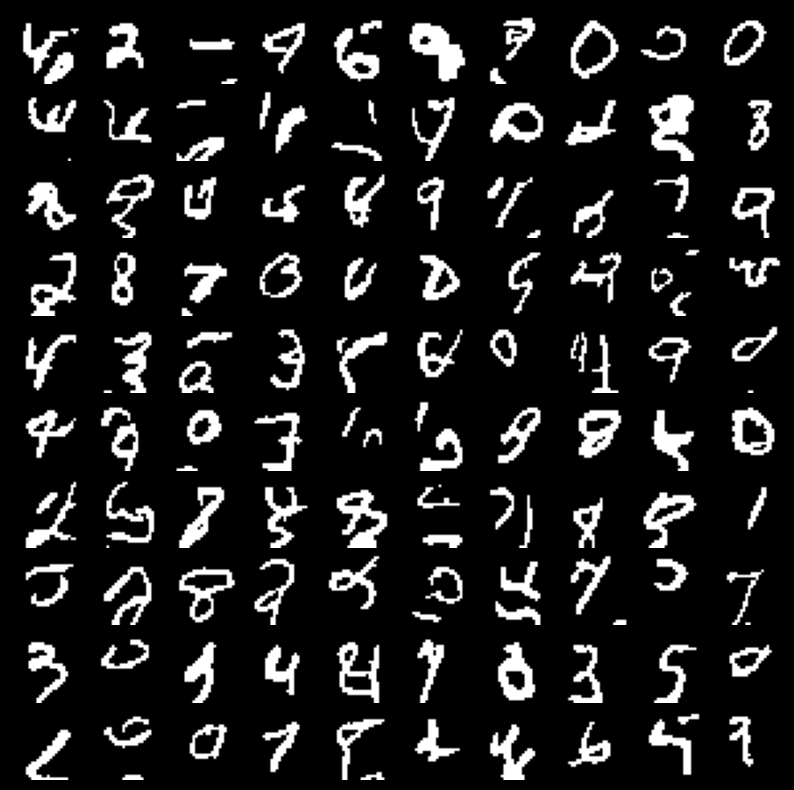

In [45]:
gen_image_batch = model.generate(28, 28, 100, jax.random.key(123))
display_image_grid(gen_image_batch, (10, 10))